<h1> Prevendo o Nível de Satisfação dos Clientes do Santander </h1>

In [133]:
# Import das biblíotecas
import pandas as pd
import sklearn as skl
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import auc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
import sklearn.metrics
from sklearn.metrics import confusion_matrix
import pickle
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [52]:
# Carregando os dados
dados_treino = pd.read_csv('dados/train.csv')

In [3]:
# Visualizando o shape dos dados
print(dados_treino.shape)

(76020, 371)


In [4]:
# Visualizando os tipos de dados
print(dados_treino.dtypes.value_counts())

int64      260
float64    111
dtype: int64


In [5]:
# Resumo estatístico dos dados
round(dados_treino.describe(), 2)

,ID,var3,var15,imp_ent_var16_ult1,imp_op_var39_comer_ult1,imp_op_var39_comer_ult3,imp_op_var40_comer_ult1,imp_op_var40_comer_ult3,imp_op_var40_efect_ult1,imp_op_var40_efect_ult3,...,saldo_medio_var33_hace2,saldo_medio_var33_hace3,saldo_medio_var33_ult1,saldo_medio_var33_ult3,saldo_medio_var44_hace2,saldo_medio_var44_hace3,saldo_medio_var44_ult1,saldo_medio_var44_ult3,var38,TARGET
count,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,...,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00,76020.00
mean,75964.05,-1523.20,33.21,86.21,72.36,119.53,3.56,6.47,0.41,0.57,...,7.94,1.37,12.22,8.78,31.51,1.86,76.03,56.61,117235.81,0.04
std,43781.95,39033.46,12.96,1614.76,339.32,546.27,93.16,153.74,30.60,36.51,...,455.89,113.96,783.21,538.44,2013.13,147.79,4040.34,2852.58,182664.60,0.19
min,1.00,-999999.00,5.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5163.75,0.00
25%,38104.75,2.00,23.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,67870.61,0.00
50%,76043.00,2.00,28.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,106409.16,0.00
75%,113748.75,2.00,40.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,118756.25,0.00
max,151838.00,238.00,105.00,210000.00,12888.03,21024.81,8237.82,11073.57,6600.00,6600.00,...,50003.88,20385.72,138831.63,91778.73,438329.22,24650.01,681462.90,397884.30,22034738.76,1.00


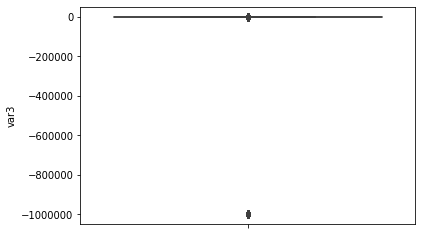

In [6]:
# Visualizando a distribuição da variável 

sns.boxplot(dados_treino['var3'], orient = 'v')

In [57]:
# Visualizando os valores únicos da variável
dados_treino['var3'].value_counts()

 2         74165
 8           138
-999999      116
 9           110
 3           108
           ...  
 177           1
 87            1
 151           1
 215           1
 191           1
Name: var3, Length: 208, dtype: int64

In [8]:
# Resumo estatístico da variável
dados_treino['var3'].describe()

count     76020.000000
mean      -1523.199277
std       39033.462364
min     -999999.000000
25%           2.000000
50%           2.000000
75%           2.000000
max         238.000000
Name: var3, dtype: float64

In [41]:
# Substituindo os valores -999999 por 0 
dados_treino['var3'] = dados_treino['var3'].replace(-999999, 0)

In [42]:
# Visualizando os dados após a mudança
dados_treino['var3'].describe()

count    76020.000000
mean         2.713431
std          9.448525
min          0.000000
25%          2.000000
50%          2.000000
75%          2.000000
max        238.000000
Name: var3, dtype: float64

In [9]:
round(dados_treino['TARGET'].value_counts() / dados_treino.shape[0] * 100, 2)

0    96.04
1     3.96
Name: TARGET, dtype: float64

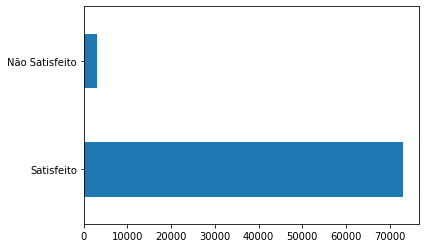

In [10]:
#Visualizando a distribuição da variável target
target = dados_treino['TARGET'].copy()
target = target.replace(1, 'Não Satisfeito')
target = target.replace(0, 'Satisfeito')
target.value_counts().plot(kind ='barh')
plt.show()

In [11]:
# Removendo as variáveis que possuem média e desvio padrão igual a zero. 
colunas = []
for i in dados_treino.columns:
    if dados_treino[i].std() == 0:
        print(i)
        print('Média:', np.mean(dados_treino[i]))
        print('Variância:', np.var(dados_treino[i]))
        print('\n\nCorrelação:', np.std(dados_treino[i]))
        colunas.append(i)


ind_var2_0
Média: 0.0
Variância: 0.0


Correlação: 0.0
ind_var2
Média: 0.0
Variância: 0.0


Correlação: 0.0
ind_var27_0
Média: 0.0
Variância: 0.0


Correlação: 0.0
ind_var28_0
Média: 0.0
Variância: 0.0


Correlação: 0.0
ind_var28
Média: 0.0
Variância: 0.0


Correlação: 0.0
ind_var27
Média: 0.0
Variância: 0.0


Correlação: 0.0
ind_var41
Média: 0.0
Variância: 0.0


Correlação: 0.0
ind_var46_0
Média: 0.0
Variância: 0.0


Correlação: 0.0
ind_var46
Média: 0.0
Variância: 0.0


Correlação: 0.0
num_var27_0
Média: 0.0
Variância: 0.0


Correlação: 0.0
num_var28_0
Média: 0.0
Variância: 0.0


Correlação: 0.0
num_var28
Média: 0.0
Variância: 0.0


Correlação: 0.0
num_var27
Média: 0.0
Variância: 0.0


Correlação: 0.0
num_var41
Média: 0.0
Variância: 0.0


Correlação: 0.0
num_var46_0
Média: 0.0
Variância: 0.0


Correlação: 0.0
num_var46
Média: 0.0
Variância: 0.0


Correlação: 0.0
saldo_var28
Média: 0.0
Variância: 0.0


Correlação: 0.0
saldo_var27
Média: 0.0
Variância: 0.0


Correlação: 0.0
saldo_var41


In [12]:
# Removendo as colunas
dados_treino.drop(colunas, axis = 1, inplace = True)

In [13]:
# Criando as variáveis x e y para efetuar a eliminação recursiva das variáveis
valores = dados_treino.values
x = pd.DataFrame(valores[:,0:335], columns = dados_treino.columns[0:335])
y = dados_treino['TARGET']

In [14]:
# Removendo a variável target dos dados
dados_treino.drop('TARGET', axis = 1, inplace = True)

In [15]:
# Eliminação Recursiva de Variáveis
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

# Criação do modelo
modelo = LogisticRegression()

# RFE
rfe = RFE(modelo, 15)
fit = rfe.fit(x, y)

In [16]:
# Coletando as melhores variáveis
variaveis = []
for i,k in enumerate(fit.support_):
    if k == True:
        variaveis.append(dados_treino.columns[i])

In [17]:
# Criando um dataframe com as melhores variáveis
dt = dados_treino[variaveis]
dt['TARGET'] = y

In [18]:
# Visualizando a correlação entre as variáveis
dt.corr()

,var15,num_var5_0,num_var5,num_var30_0,num_var30,num_var35,num_var39_0,num_var41_0,num_var42_0,num_var42,saldo_var20,saldo_var33,num_meses_var5_ult3,num_meses_var39_vig_ult3,saldo_medio_var44_hace2,TARGET
var15,1.000000,-0.103918,-0.098478,0.314529,0.158415,0.210186,0.077865,0.055465,0.211886,0.031443,-0.013869,0.028527,-0.070733,0.073303,0.029180,0.101322
num_var5_0,-0.103918,1.000000,0.298778,0.124373,-0.000475,-0.226485,0.054590,0.099664,0.181983,0.004950,-0.048749,-0.049750,0.201978,0.001892,-0.005240,-0.028912
num_var5,-0.098478,0.298778,1.000000,-0.030087,0.744330,0.497398,0.158861,0.174860,-0.005538,0.839574,-0.015439,-0.012992,0.903272,0.052305,0.007158,-0.134095
num_var30_0,0.314529,0.124373,-0.030087,1.000000,0.484082,0.278968,0.154881,0.141651,0.840657,0.194289,-0.003076,-0.021133,0.055135,0.098877,0.004440,-0.033903
num_var30,0.158415,-0.000475,0.744330,0.484082,1.000000,0.731010,0.227383,0.214403,0.356102,0.898119,0.004154,-0.007743,0.756298,0.102948,0.007288,-0.138289
num_var35,0.210186,-0.226485,0.497398,0.278968,0.731010,1.000000,0.337581,0.310577,0.224974,0.694667,-0.001137,0.021546,0.534185,0.177463,0.027811,-0.076872
num_var39_0,0.077865,0.054590,0.158861,0.154881,0.227383,0.337581,1.000000,0.950177,0.166143,0.215611,-0.026452,-0.018454,0.175264,0.732653,0.004937,-0.029181
num_var41_0,0.055465,0.099664,0.174860,0.141651,0.214403,0.310577,0.950177,1.000000,0.158900,0.208579,-0.027005,-0.019680,0.187422,0.749091,0.002133,-0.030302
num_var42_0,0.211886,0.181983,-0.005538,0.840657,0.356102,0.224974,0.166143,0.158900,1.000000,0.281360,-0.002391,-0.031457,0.051635,0.099234,0.000512,-0.017944
num_var42,0.031443,0.004950,0.839574,0.194289,0.898119,0.694667,0.215611,0.208579,0.281360,1.000000,0.005774,-0.009493,0.813847,0.087499,0.007571,-0.135693


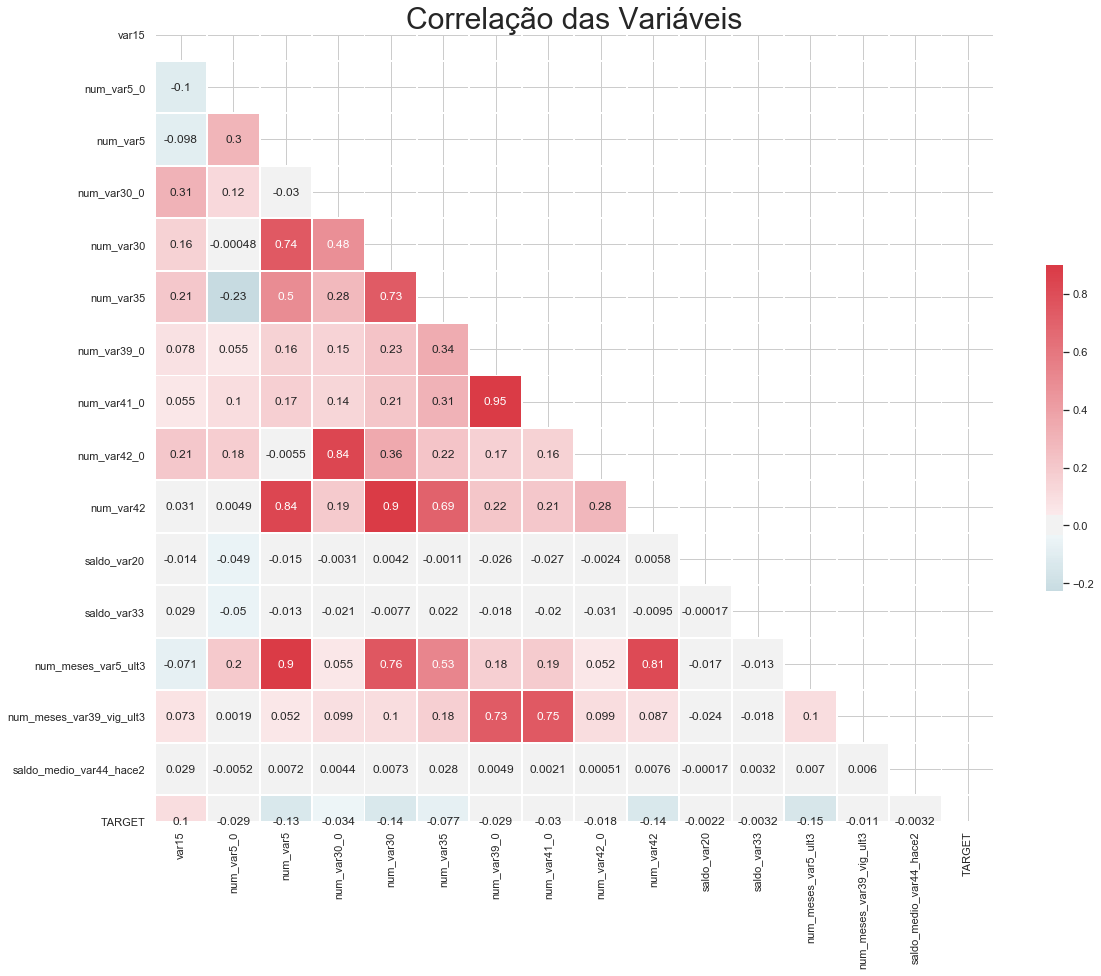

In [60]:
# Corr plot dos dados
sns.set(style="white")
corr = dt.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(18.8, 30))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlação das Variáveis', size = 30)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.9, cbar_kws={"shrink": .2}, annot = True)
plt.grid()

plt.show()

In [20]:
# Verificando o Skew dos dados
dt.skew()

var15                         1.578367
num_var5_0                   -2.679003
num_var5                     -0.620356
num_var30_0                  10.584532
num_var30                     0.273769
num_var35                     1.302883
num_var39_0                  -0.378306
num_var41_0                  -0.633122
num_var42_0                  23.593660
num_var42                    -0.339927
saldo_var20                 163.855539
saldo_var33                 106.971908
num_meses_var5_ult3          -0.702865
num_meses_var39_vig_ult3     -1.366315
saldo_medio_var44_hace2     151.919257
TARGET                        4.723842
dtype: float64

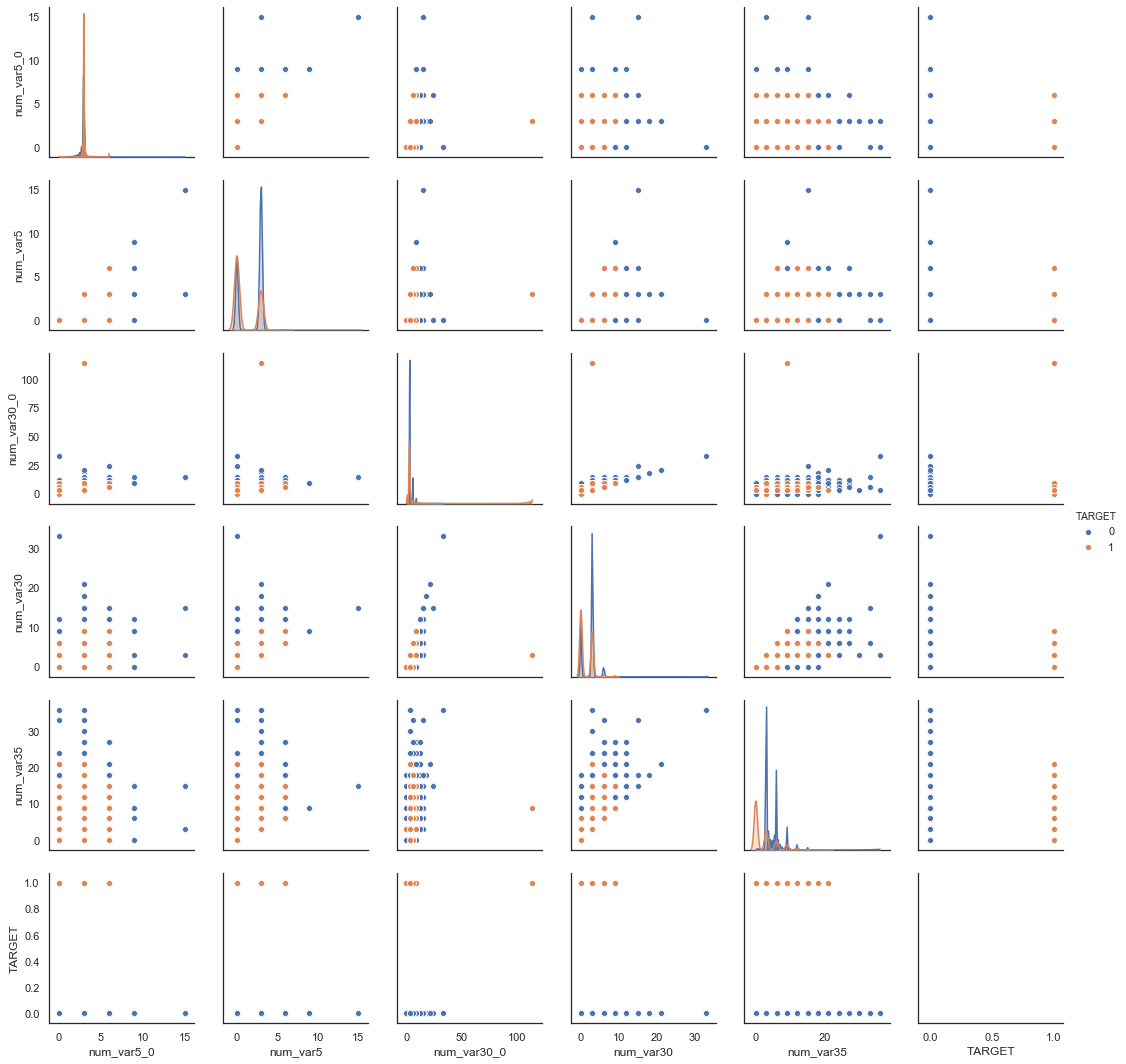

In [21]:
# Visualizando os dados 
sns.set(style="white")
sns.pairplot(data = dt, hue = 'TARGET', vars = ["num_var5_0", "num_var5", "num_var30_0", "num_var30", "num_var35",  "TARGET"])
plt.show()

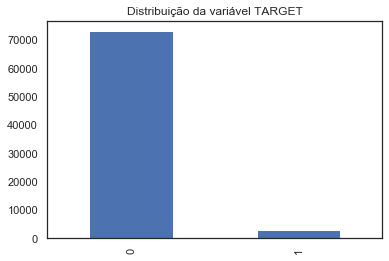

In [22]:
# Visualizando a distribuição da variável TARGET
dt['TARGET'].value_counts().plot(kind = 'bar')
plt.title('Distribuição da variável TARGET')
plt.show()

In [25]:
# Como a variável TARGET está totalmente desbalanceada será feita a reamostragem dos dados para que o modelo não seja treinado
# de forma tendenciosa.
from sklearn.utils import resample

df_majority = dt[dt.TARGET==0]
df_minority = dt[dt.TARGET==1]
 
# Reamostragem dos dados com valor = 1

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=40012,   
                                 random_state=123) 
 
# Dados balanceados
dados_balanceados = pd.concat([df_majority, df_minority_upsampled])


# Visualizando a mudança
dados_balanceados.TARGET.value_counts()

0    73012
1    40012
Name: TARGET, dtype: int64

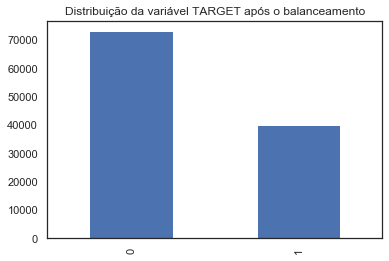

In [137]:
# Distribuição da variável TARGET
dados_balanceados['TARGET'].value_counts().plot(kind = 'bar')
plt.title('Distribuição da variável TARGET após o balanceamento')
plt.show()


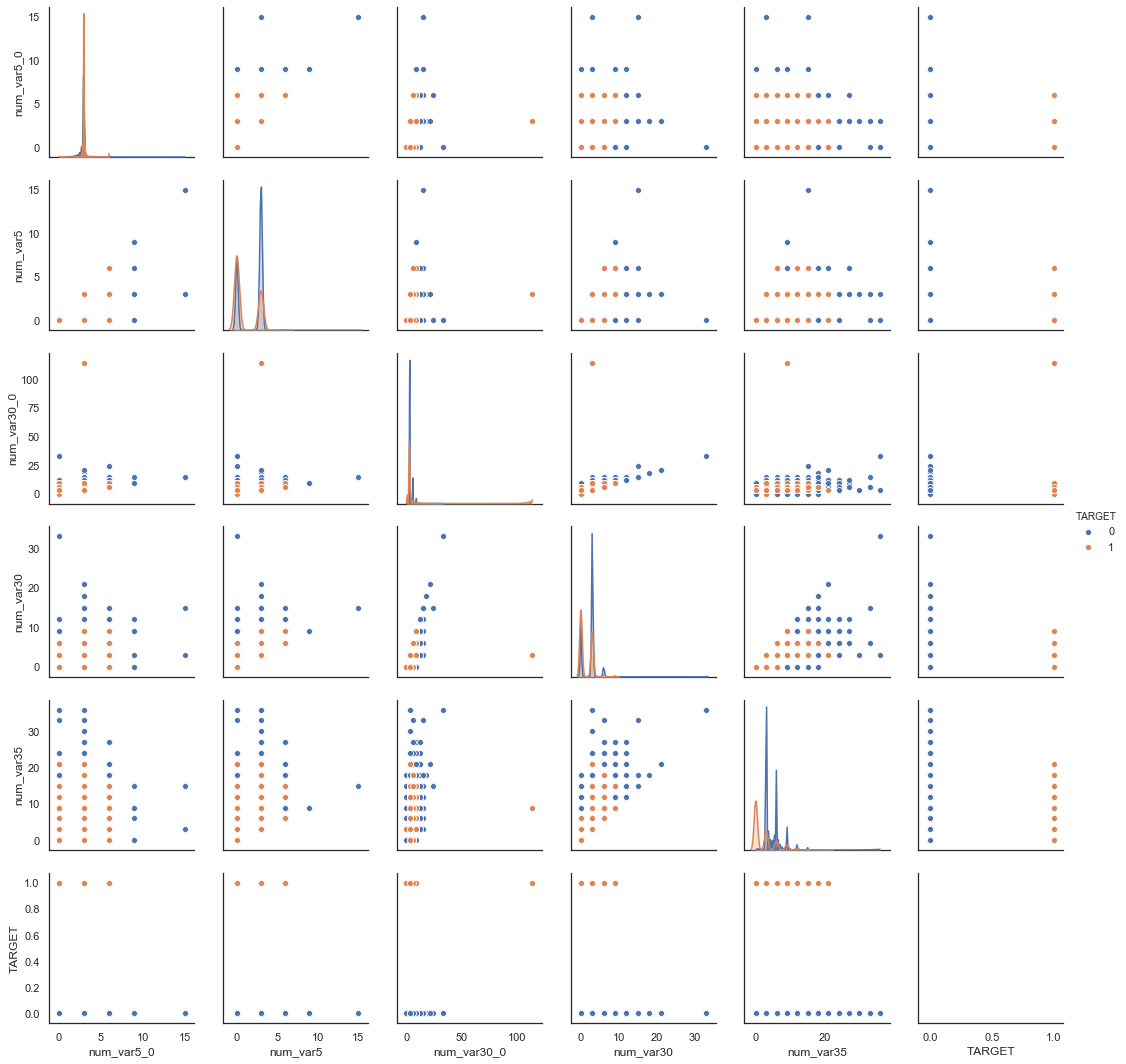

In [138]:
# Visualizando os dados após a mudança na variável TARGET
sns.set(style="white")
sns.pairplot(data = dt, hue = 'TARGET', vars = ["num_var5_0", "num_var5", "num_var30_0", "num_var30", "num_var35",  "TARGET"])
plt.show()

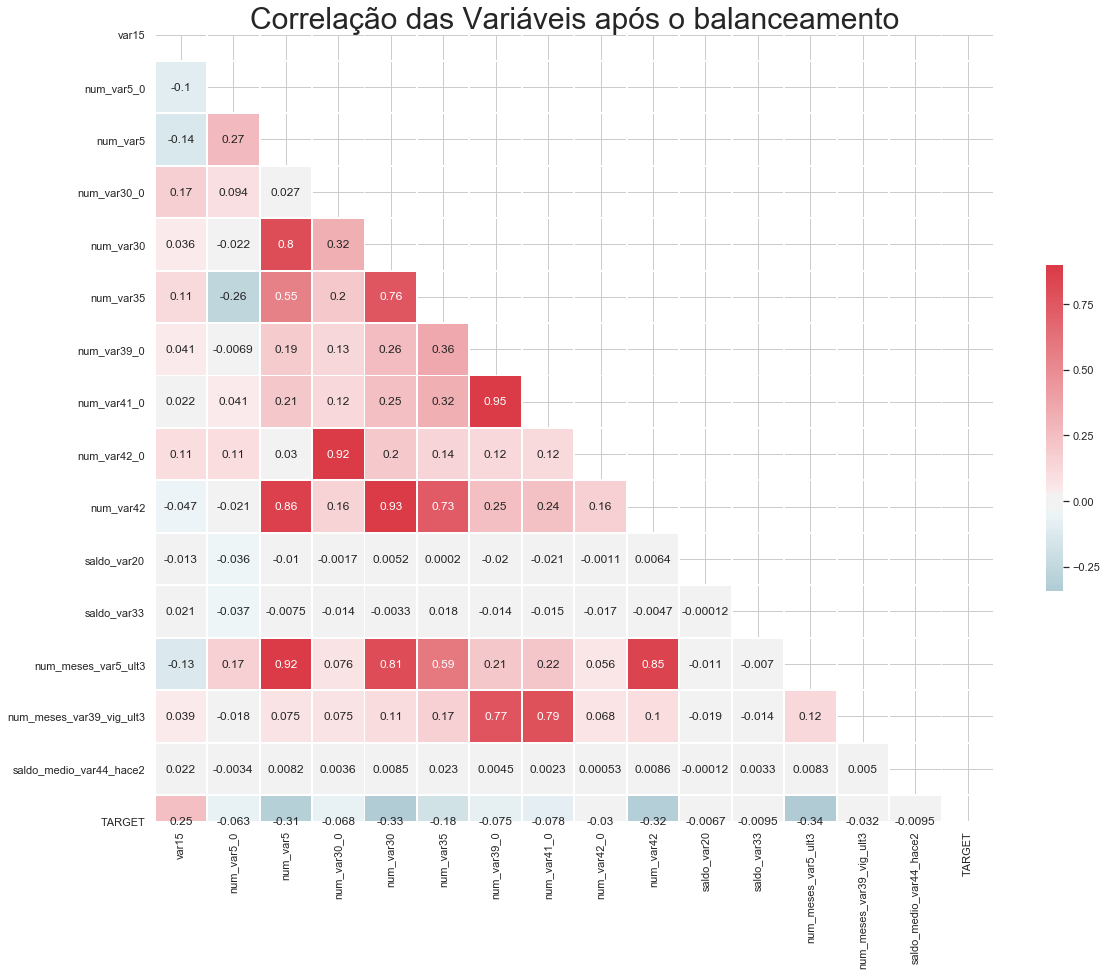

In [59]:
# Verificando se ocorreu alguma mudança na correlação dos dados com a mudança 
sns.set(style="white")
corr = dados_balanceados.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(18.8, 30))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
plt.title('Correlação das Variáveis após o balanceamento', size = 30)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.9, cbar_kws={"shrink": .2}, annot = True)
plt.grid()

plt.show()

<h2> Modelo de Regressão Logistica </h2>

In [31]:
#Criando os dados de treino e teste
valores = dados_balanceados.values

x = valores[:,0:10]
y = dados_balanceados['TARGET']

(x_treino, x_teste, y_treino, y_teste) = skl.model_selection.train_test_split(x, y, test_size=0.30, random_state=1)

In [32]:
# Treinando o modelo
modelo = LogisticRegression()

# Treinamento do modelo
modelo.fit(x_treino, y_treino)

# Verificando o score
print('Score do modelo:',modelo.score(x_teste,y_teste) * 100)

# Fazendo previsões
previsoes = modelo.predict(x_teste)


Score do modelo: 73.99728677598208


In [33]:
confusion = pd.DataFrame(confusion_matrix(previsoes, y_teste), columns=['Satisfeito', 'Não Satisfeito'], index = ['Satisfeito', 'Não Satisfeito'])
confusion.head()

,Satisfeito,Não Satisfeito
Satisfeito,19245,6051
Não Satisfeito,2766,5846


In [95]:
modelos = []
modelos.append(['Regressão Logistica',73.99 ])

<h1> Naive Bayes </h1>

In [34]:
# Importando os módulos
from sklearn.naive_bayes import GaussianNB

modelo = GaussianNB()
modelo.fit(x_treino, y_treino)

print(modelo.score(x_teste, y_teste) * 100)

# Previsões
previsoes_nb = modelo.predict(x_teste)

confusion_nb = pd.DataFrame(confusion_matrix(previsoes_nb, y_teste), columns=['Satisfeito', 'Não Satisfeito'], index = ['Satisfeito', 'Não Satisfeito'])

confusion_nb.head()


70.1633832723841


,Satisfeito,Não Satisfeito
Satisfeito,17467,5573
Não Satisfeito,4544,6324


In [96]:
modelos.append(['Naive Bayes',70.16])

<h1> Decision Tree </h1>

In [35]:
from sklearn.tree import DecisionTreeClassifier

modelo = DecisionTreeClassifier()
modelo.fit(x_treino, y_treino)

print(modelo.score(x_teste, y_teste) * 100)

previsoes_decision_tree = modelo.predict(x_teste)

confusion_dt = pd.DataFrame(confusion_matrix(previsoes_decision_tree, y_teste), columns=['Satisfeito', 'Não Satisfeito'], index = ['Satisfeito', 'Não Satisfeito'])

confusion_dt.head()

78.06122448979592


,Satisfeito,Não Satisfeito
Satisfeito,19039,4467
Não Satisfeito,2972,7430


In [97]:
modelos.append(['Decision Tree',78.06])
modelos

[['Regressão Logistica', 73.99],
 ['Naive Bayes', 70.16],
 ['Decision Tree', 78.06]]

<h2> Suport Vector Machine </h2>

In [36]:
# Importando o modulo do SVM
from sklearn.svm import SVC

modelo_svm = SVC()
modelo_svm.fit(x_treino, y_treino)

# Visualizando o Score
print(modelo_svm.score(x_teste,y_teste) * 100)

#Fazendo Previsões 
previsoes_svm = modelo.predict(x_teste)

#Fazendo previsões
confusion_svm =  pd.DataFrame(confusion_matrix(previsoes_svm, y_teste), columns=['Satisfeito', 'Não Satisfeito'], index = ['Satisfeito', 'Não Satisfeito'])
confusion_svm.head()

77.41241005072548


,Satisfeito,Não Satisfeito
Satisfeito,19039,4467
Não Satisfeito,2972,7430


In [99]:
modelos.append(['Suport Vector Machine',77.41])
modelos

[['Regressão Logistica', 73.99],
 ['Naive Bayes', 70.16],
 ['Decision Tree', 78.06],
 ['Suport Vector Machine', 77.41]]

<h2> Random Forest </h2>

In [37]:
from sklearn.ensemble import RandomForestClassifier

modelo = RandomForestClassifier()

modelo.fit(x_treino, y_treino)
print('Score: ', modelo.score(x_teste, y_teste) * 100)

previsoes = modelo.predict(x_teste)

confusion_svm =  pd.DataFrame(confusion_matrix(previsoes, y_teste), columns=['Satisfeito', 'Não Satisfeito'], index = ['Satisfeito', 'Não Satisfeito'])
confusion_svm.head()

Score:  78.06417364633714


,Satisfeito,Não Satisfeito
Satisfeito,19052,4479
Não Satisfeito,2959,7418


In [101]:
modelos.append(['Random Forest',77.41])

<h2> Desempenho dos Modelos </h2>

In [130]:
# O modelo selecionado foi o Decision Tree que teve a acurácia de 78.06%
pd.DataFrame(modelos, columns = ['Modelo', 'Score'])

,Modelo,Score
0,Regressão Logistica,73.99
1,Naive Bayes,70.16
2,Decision Tree,78.06
3,Suport Vector Machine,77.41
4,Random Forest,77.41


<h2> Salvando o modelo selecionado (Decision Tree) </h2>

In [136]:
arquivo = 'modelo_classificador_decision_tree.sav'
pickle.dump(modelo, open(arquivo, 'wb'))